# ДЗ6. Feature Engineering, Feature Selection, part II

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

import shap
shap.initjs()

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

**Подготовим данные**

In [2]:
data = pd.read_csv('./data/assignment_2_train.csv')
lb = pd.read_csv('./data/assignment_2_test.csv')

In [3]:
X_data = data.drop('isFraud', axis=1)
y_data = data['isFraud']
X_lb = lb.drop('isFraud', axis=1)
y_lb = lb['isFraud']

## Выбрать модель и схему валидации

**Задание 0:** выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [4]:
class EvaluationModel():
    
    def __init__(self, X: pd.DataFrame, 
                       y: pd.Series = None, 
                       stata_model: pd.DataFrame = None, 
                       operation: str = None):
        
        self.X = X.copy()
        self.y = y
        self.stata_model = stata_model
        self.operation = operation
        self.cat_features = X.select_dtypes(include=np.object).columns.to_list()
        
    def label_encoder(self):

        le = LabelEncoder()
        for feature in self.cat_features:
            cat_value = list(self.X[feature].values.astype('str'))
            le.fit(cat_value)
            self.X[feature] = le.transform(cat_value)

        return self.X
    
    def cross_validation(self, model):
    
        fold_train_scores, fold_valid_scores = [], []
        cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

        for train_idx, valid_idx in cv_strategy.split(self.X, self.y):
            X_train_cv, X_valid_cv = self.X.loc[train_idx], self.X.loc[valid_idx]
            y_train_cv, y_valid_cv = self.y.loc[train_idx], self.y.loc[valid_idx]

            model.fit(X_train_cv, y_train_cv)
            y_train_cv_pred = model.predict_proba(X_train_cv)[:, 1]
            y_valid_cv_pred = model.predict_proba(X_valid_cv)[:, 1]
            fold_train_scores.append(roc_auc_score(y_train_cv, y_train_cv_pred))
            fold_valid_scores.append(roc_auc_score(y_valid_cv, y_valid_cv_pred))

        train_scores = round(np.mean(fold_train_scores), 4)
        valid_scores = round(np.mean(fold_valid_scores), 4)

        conf_interval = 0.95 

        left_bound = np.percentile(fold_valid_scores, ((1 - conf_interval) / 2) * 100)
        right_bound = np.percentile(fold_valid_scores, (conf_interval + ((1 - conf_interval) / 2)) * 100)
        interval = f'{round(left_bound, 3)}/{round(right_bound, 3)}'

        return train_scores, valid_scores, interval
    
    def collection_statistic(self, model, X_train, y_train, X_valid, y_valid):
        
        train_scores, valid_scores, interval = self.cross_validation(model)
        
        self.stata_model.loc[f'{self.operation}', 'train_Hold_Out'] = \
                round(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]), 4)
        self.stata_model.loc[f'{self.operation}', 'valid_Hold_Out'] = \
                round(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]), 4)
        
        self.stata_model.loc[f'{self.operation}', 'train_KFold'] = train_scores
        self.stata_model.loc[f'{self.operation}', 'valid_KFold'] = valid_scores
        self.stata_model.loc[f'{self.operation}', 'valid_interval'] = interval
        
        return self.stata_model
    
    def xgb_classifier(self):
        
        self.X = self.label_encoder()
        
        X_train, X_valid = train_test_split(self.X, train_size=0.7, shuffle=True, random_state=5)
        y_train, y_valid = train_test_split(self.y, train_size=0.7, shuffle=True, random_state=5)
        
        params_xgb = {"n_estimators": 100,
                      "objective": "binary:logistic",
                      "eval_metric": "auc",
                      "random_state": 42}

        model_xgb = XGBClassifier(**params_xgb)
        model_xgb.fit(X=X_train, y=y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                    early_stopping_rounds=25,
                    verbose=20)
        
        self.stata_model = self.collection_statistic(model_xgb, X_train, y_train, X_valid, y_valid)
        
        return model_xgb, self.stata_model

In [5]:
stata_model = pd.DataFrame(columns=['train_Hold_Out', 'valid_Hold_Out', 'train_KFold', 'valid_KFold', 'valid_interval'])
X_data_base = X_data.copy()
X_data_base.shape

(180000, 393)

In [6]:
model, stata_model = EvaluationModel(X_data_base, y_data, stata_model, operation='baseline').xgb_classifier()
stata_model

[0]	validation_0-auc:0.76397	validation_1-auc:0.75374
[20]	validation_0-auc:0.94058	validation_1-auc:0.91899
[40]	validation_0-auc:0.96228	validation_1-auc:0.93041
[60]	validation_0-auc:0.97295	validation_1-auc:0.93914
[80]	validation_0-auc:0.97910	validation_1-auc:0.94112
[99]	validation_0-auc:0.98553	validation_1-auc:0.94515


,train_Hold_Out,valid_Hold_Out,train_KFold,valid_KFold,valid_interval
baseline,0.971,0.9709,0.9829,0.9442,0.936/0.953


## Оценка важности признаков

**Задание 1:** использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

Text(0.5, 1.0, 'What are the top important features to start with?')

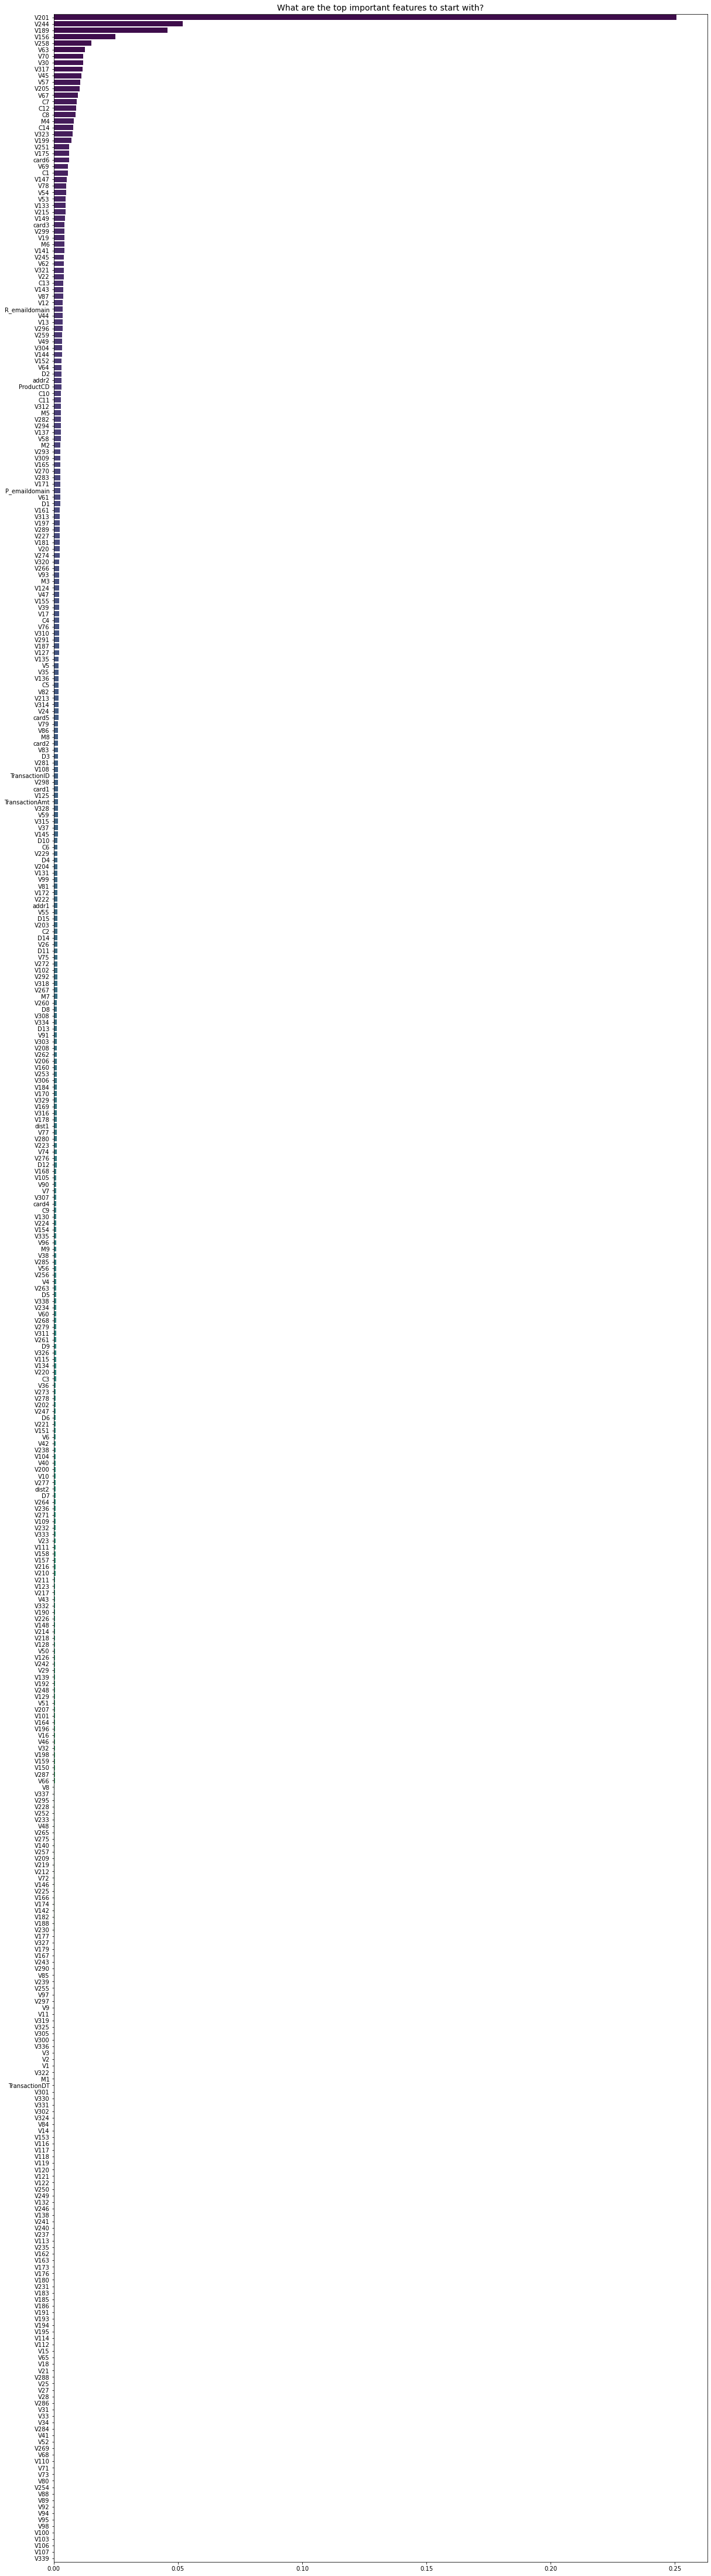

In [12]:
importances = model.feature_importances_
idx = np.argsort(importances)[::-1]
feature_names = X_data_base.columns

plt.figure(figsize=(20, 80))
sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

## Удалить признаки, переобучить модель

**Задание 2:** удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [13]:
X_data_base_import_own = X_data_base.copy()

for i in idx:
    if importances[i]<=0:
        X_data_base_import_own.drop(feature_names[i], axis=1, inplace=True)
        
X_data_base_import_own.shape

(180000, 306)

In [14]:
model_own, stata_model = EvaluationModel(X_data_base_import_own, y_data, stata_model, 
                                        operation='importances_own').xgb_classifier()
stata_model

[0]	validation_0-auc:0.76397	validation_1-auc:0.75374
[20]	validation_0-auc:0.93893	validation_1-auc:0.91782
[40]	validation_0-auc:0.96249	validation_1-auc:0.93235
[60]	validation_0-auc:0.97346	validation_1-auc:0.93832
[80]	validation_0-auc:0.98175	validation_1-auc:0.94130
[99]	validation_0-auc:0.98595	validation_1-auc:0.94396


,train_Hold_Out,valid_Hold_Out,train_KFold,valid_KFold,valid_interval
baseline,0.971,0.9709,0.9829,0.9442,0.936/0.953
importances_own,0.971,0.9709,0.9832,0.9447,0.936/0.952


## Permutation importance

**Задание 3:** использовать permutation importance, выполнить задание 1 и 2.

In [15]:
X_data_base_import_perm = X_data_base.copy()

X_data_base_import_perm = EvaluationModel(X_data_base_import_perm).label_encoder()

X_train, X_valid = train_test_split(X_data_base_import_perm, train_size=0.7, shuffle=True, random_state=5)
y_train, y_valid = train_test_split(y_data, train_size=0.7, shuffle=True, random_state=5)

In [16]:
importance = permutation_importance(model, X_valid, y_valid, scoring="roc_auc", n_jobs=6, random_state=1)

In [17]:
importance_scores = pd.DataFrame({"features": X_valid.columns,
                                  "importance-mean": importance.importances_mean,
                                  "importance-std": importance.importances_std})

importance_scores = importance_scores.sort_values(by="importance-mean", ascending=False)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

In [18]:
X_data_base_import_perm.drop(decrease_scores['features'], axis=1, inplace=True)
X_data_base_import_perm.shape

(180000, 237)

In [19]:
model_per, stata_model = EvaluationModel(X_data_base_import_perm, y_data, stata_model, 
                                        operation='importances_permutation').xgb_classifier()
stata_model

[0]	validation_0-auc:0.78183	validation_1-auc:0.77993
[20]	validation_0-auc:0.93930	validation_1-auc:0.91783
[40]	validation_0-auc:0.96232	validation_1-auc:0.93448
[60]	validation_0-auc:0.97080	validation_1-auc:0.93816
[80]	validation_0-auc:0.97820	validation_1-auc:0.94278
[99]	validation_0-auc:0.98427	validation_1-auc:0.94551


,train_Hold_Out,valid_Hold_Out,train_KFold,valid_KFold,valid_interval
baseline,0.971,0.9709,0.9829,0.9442,0.936/0.953
importances_own,0.971,0.9709,0.9832,0.9447,0.936/0.952
importances_permutation,0.974,0.9729,0.9836,0.9463,0.941/0.957


## Shap

**Задание 4:** использовать shap, выполнить задание 1 и 2.

In [20]:
X_data_base_import_shap = X_data_base.copy()

X_data_base_import_shap = EvaluationModel(X_data_base_import_shap).label_encoder()

X_train, X_valid = train_test_split(X_data_base_import_shap, train_size=0.7, shuffle=True, random_state=5)
y_train, y_valid = train_test_split(y_data, train_size=0.7, shuffle=True, random_state=5)

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

In [22]:
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

features = rf_resultX.mean()[rf_resultX.mean()>0].index.to_list()

X_data_base_import_shap.drop(features, axis=1, inplace=True)
X_data_base_import_shap.shape

(180000, 283)

In [23]:
model_shap, stata_model = EvaluationModel(X_data_base_import_shap, y_data, stata_model, 
                                        operation='importances_shap').xgb_classifier()
stata_model

[0]	validation_0-auc:0.76515	validation_1-auc:0.75386
[20]	validation_0-auc:0.93827	validation_1-auc:0.91492
[40]	validation_0-auc:0.95956	validation_1-auc:0.92981
[60]	validation_0-auc:0.97060	validation_1-auc:0.93704
[80]	validation_0-auc:0.97877	validation_1-auc:0.94076
[99]	validation_0-auc:0.98535	validation_1-auc:0.94322


,train_Hold_Out,valid_Hold_Out,train_KFold,valid_KFold,valid_interval
baseline,0.971,0.9709,0.9829,0.9442,0.936/0.953
importances_own,0.971,0.9709,0.9832,0.9447,0.936/0.952
importances_permutation,0.974,0.9729,0.9836,0.9463,0.941/0.957
importances_shap,0.9737,0.9727,0.9829,0.9432,0.937/0.953


## shap.summary_plot и shap.decision_plot

**Задание 5:** построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

**shap.summary_plot**

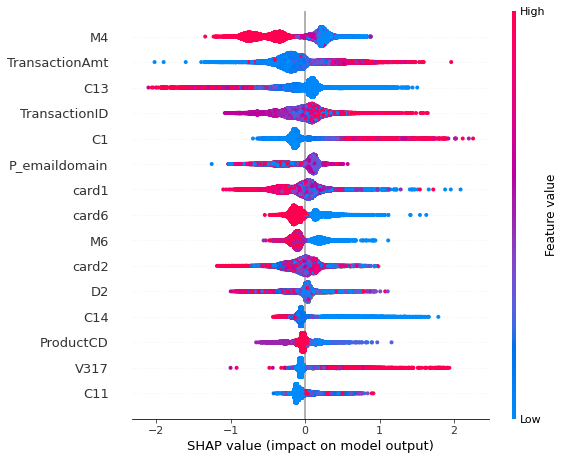

In [24]:
shap.summary_plot(shap_values, X_valid, max_display=15)

**Вывод:** С1, V317, TransactionID, TransactionAMT оказывают наибольшее влияние в положительную сторону, а C13 в отрицательную.

**shap.decision_plot**

In [25]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(40)
features = X_valid.iloc[select]
features_display = X_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-4.11258455]


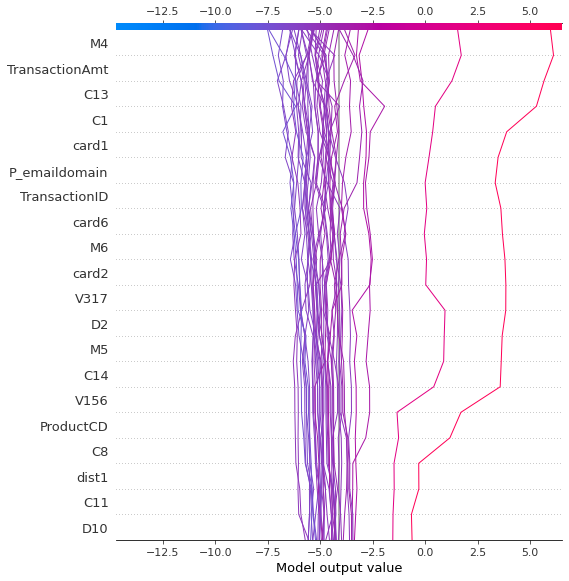

In [26]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:60])

**Вывод:** M4, TransactionAMT, C13 - больше других оказывают влияние в положительную сторону